# FE MINI PROEJCT: DS CHAMPS: WEB SCRAPING

Team :Anusha Nagineni, Dharmendra Dash, Adiseshulu Pujari

###### Project Description:
We are web scraping Daily Essential products from 3 e-commerce websites (DMart, Grofers and BigBasket) and provide best recommendation for the products.  

###### Below 4 tasks will be performed in this project.
 
    A. Data Acquisition  
    B. Data Cleaning 
    C. Data Integration 
    D. Exploratory Data Analysis and Recommendation

A. Data Acquisition : We fetch product data from e-commerce websites using Web Scraping. 

Steps followed to Web Scrape:
 1.  Identify products that we want to scrap from our chosen 3 online e-commerce platforms.
 2.  Search the products on the browser using API URLs to fetch product info.
 3.  Understand elements in the response from the webiste API call to get product info.
 4.  Program to fetch product details like name, quantity, price, discountprice if any and save the data to csv files.

     

In [1]:
#Necessary Library Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests 


###### Products and Categories to be scrapped

In [2]:
df_products = pd.read_csv("products.csv" )
print("Total categories to be scrapped ", len(df_products["Product"].unique()))  
print("Total products to be scrapped ", df_products.shape[0])  

Total categories to be scrapped  30
Total products to be scrapped  142


##### Scrapping DMart

 - We need to pass the page number to the the URL for DMart.
 - We are limiting scrapting to 2 pages
 - DMart requires a Store Id be sent in the header to be sent. Otherwise, it will return wrong results

In [3]:
#Dmart Scrapping
def findProducts_dmart(search_brand, search_product):
    #Max pages to scrap
    max_pages = 2
    #Product full name
    searchStr = search_brand + " " + search_product
    #URL for page 
    url_page  = "https://digital.dmart.in/api/v1/search/{0}?page={1}"
    #Necessary request headers
    headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36'}
    
    #DMart requires store Id 
    headers['storeId']='10657'
    #Replace spaces in the product name with +
    search_str_encoded = searchStr.replace(" ","+")
    
    #Extract product data into a dictionary object
    product_data=[]
    for page in range(1,max_pages):
        url = url_page.format(search_str_encoded, page)
        #print(url)
        productsInfo = requests.get(url, headers=headers).json()
        #If the scrapping did not yield any products, just continue with next product
        products=productsInfo.get( 'suggestionView')
        if(not products):
            continue
     
        for product in  products:
            skus = product['skus']
            for sku in skus:  
                if(sku['defining']):
                    name =   sku.get( 'name',  product['name']).strip()
                    product_data.append({"search_brand": search_brand, "search_product": search_product, "shop": "DMart",   "product_name": name,"weight": sku['defining'][0]['volume'], "mrp": sku['price_MRP'], "special_price": sku['price_SALE'] })
    #Return the scrapped data           
    return product_data

##### Scrapping Grofers
 - We need to pass the page number to the the URL for Grofers.
 - Grofers requires a special header to be sent
 - We are limiting scrapting to 2 pages


In [4]:
#Grofers Scrapping
def findProducts_grofers(search_brand, search_product):
    #Max pages to scrap
    max_pages = 2
    #Product full name
    searchStr = search_brand + " " + search_product
    #URL for page. This should include Longitude and Latitude as well. 
    url_page  = "https://grofers.com/v5/search/merchants/26659/products/?lat=17.4196281427546&lon=78.3790778036223&q={0}&suggestion_type=0&t=1&start={1}&size=48"
    #Necessary request headers
    headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36'}
    #Grofers requires this header 
    headers['app_client'] = 'consumer_web' 
    #Replace spaces in the product name with +
    search_str_encoded = searchStr.replace(" ","+")
    #Extract product data into a dictionary object
    product_data=[]
    for page in range(1,max_pages):
        start_pos = (page-1)*48
        if(start_pos==0):
            start_pos = 1
        #Create page specific URL
        url = url_page.format(search_str_encoded, start_pos)
        productsInfo = requests.get(url, headers=headers).json()
        #If the scrapping did not yield any products, just continue with next product
        products= productsInfo.get('products')
        if(not products):
            break
        for product in  products:
            prod_variants = product['variant_info']
            for var in prod_variants:
                product_data.append({"search_brand": search_brand, "search_product": search_product,   "shop": "Grofers",  "product_name": var["line_1"],"weight": var["unit"], "mrp": var["mrp"], "special_price": var["price"]})
    #Return the scrapped data    
    return product_data

##### Scrapping Bigbasket

- We need to maintain two separate URLs in the code as Big basket has different URLS for first page and other pages.
- We are limiting scrapting to 2 pages


In [5]:
#Big Basket Scrapping
def findProducts_bigbasket(search_brand, search_product):
    
    #Max pages to scrap
    max_pages = 2
    
    #Product full name
    searchStr = search_brand + " " + search_product
    
    #URL for page 1
    url_page_1 = "https://www.bigbasket.com/custompage/getsearchdata/?type=deck&slug={0}"
    
    #URL for subsequent pages
    url_for_page_n = "https://www.bigbasket.com/product/get-products/?slug={0}&page={1}&tab_type=[%22all%22]&sorted_on=relevance&listtype=ps"
    
    #Replace spaces in the product name with +
    search_str_encoded = searchStr.replace(" ","+")
    
    #Form actual URL for page 1
    url = url_page_1.format(search_str_encoded)
 
    #Necessary request headers
    headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36'}
    
    #Get the response for page 1
    productsInfo = requests.get(url, headers=headers).json()
    
    #Extract product data into a dictionary object
    products =  productsInfo['json_data']['tab_info'][0]['product_info']['products']
    product_data=[]
    for product in  products:
        options = product['all_prods']
        if(not options): 
            product_data.append({"search_brand": search_brand, "search_product": search_product, "shop": "Big Basket", "product_name": str(product['p_brand']).strip() + " " + str(product['p_desc']).strip(), "weight":product['w'], "mrp": product['mrp'], "special_price": product['sp'] })
            continue
        for option  in product['all_prods']:
            product_data.append({"search_brand": search_brand, "search_product": search_product, "shop": "Big Basket",  "product_name": str(product['p_brand']).strip() + " " + str(product['p_desc']).strip(), "weight":option['w'],
                                 "mrp": option['mrp'], "special_price": option['sp'] }) 
 
    
    #Do it for subsequent pages     
    for page in range(2,max_pages):
        newurl = url_for_page_n.format(search_str_encoded, page) 
        productsInfo = requests.get(newurl, headers=headers).json()
        products =  productsInfo['tab_info']['product_map']['all']['prods']

        for product in  products:
            options = product['all_prods']
            if(not options): 
                product_data.append({"search_brand": search_brand, "search_product": search_product, "shop": "Big Basket",    "product_name": str(product['p_brand']).strip() + " " + str(product['p_desc']).strip(), "weight":product['w'], "mrp": product['mrp'], "special_price": product['sp'] })
                continue
            for option  in product['all_prods']:
                product_data.append({"search_brand": search_brand, "search_product": search_product,  "shop": "Big Basket",  "product_name": str(product['p_brand']).strip() + " " + str(product['p_desc']).strip(), "weight":option['w'], "mrp": option['mrp'], "special_price": option['sp'] })

    #Return the scrapped data           
    return product_data
 

###### Do Web Scrapping for all 3 websites

In [6]:
# Scrapping for all sites
def scrapeAll():
    #Read all items for which scrapping is needed
    df_input   = pd.read_csv("products.csv" )
    #Define an empty dataframe to store results for each of the shops
    column_names =   ["search_brand","search_product", "shop",   "product_name", "weight", "mrp", "special_price"]
    
    df_bigbasket = pd.DataFrame(columns = column_names)
    df_dmart = pd.DataFrame(columns = column_names)
    df_grofers = pd.DataFrame(columns = column_names)
    
    #For each of the products, peform scrapping
    for ( idx , search_brand, search_product) in df_input.itertuples():
        print('Scrapping DMart for ', idx, search_brand, search_product)
        product_data = findProducts_dmart(search_brand, search_product)
        df_dmart = df_dmart.append(product_data[:3])
        
        print('Scrapping Grofers for ', idx, search_brand, search_product)
        product_data = findProducts_grofers(search_brand, search_product)
        df_grofers = df_grofers.append(product_data[:3])   
        
        print('Scrapping BigBasket for ', idx, search_brand, search_product)
        product_data = findProducts_bigbasket(search_brand, search_product)
        df_bigbasket = df_bigbasket.append(product_data[:3])

       
    #Store final results for each of the stores in separate csv file
    df_dmart.to_csv('dmartDailyEssentails.csv', index=False, encoding='utf-8')
    df_grofers.to_csv('grofersDailyEssentails.csv', index=False, encoding='utf-8')
    df_bigbasket.to_csv('big_basketDailyEssentails.csv', index=False,encoding='utf-8')

###### Scrapping Results

In [7]:
#Call scrapping routine
scrapeAll()
#Load scrapped data into data frames and look at the metrics
df_dmart  = pd.read_csv("dmartDailyEssentails.csv")
df_grofers  = pd.read_csv("grofersDailyEssentails.csv")
df_bb  = pd.read_csv("big_basketDailyEssentails.csv")

print("DMart returned products count:" , df_dmart.shape[0] )
print("Grofers returned products count:" , df_grofers.shape[0] ) 
print("Bigbasket returned products count:" , df_bb.shape[0] )


Scrapping DMart for  0 Tata Tea Tea
Scrapping Grofers for  0 Tata Tea Tea
Scrapping BigBasket for  0 Tata Tea Tea
Scrapping DMart for  1 pepsi Soft Drink
Scrapping Grofers for  1 pepsi Soft Drink
Scrapping BigBasket for  1 pepsi Soft Drink
Scrapping DMart for  2 bb royal Popcorn
Scrapping Grofers for  2 bb royal Popcorn
Scrapping BigBasket for  2 bb royal Popcorn
Scrapping DMart for  3 Gentleman Classic  Deodrant
Scrapping Grofers for  3 Gentleman Classic  Deodrant
Scrapping BigBasket for  3 Gentleman Classic  Deodrant
Scrapping DMart for  4 Anurag Cooking Oil
Scrapping Grofers for  4 Anurag Cooking Oil
Scrapping BigBasket for  4 Anurag Cooking Oil
Scrapping DMart for  5 Appy Fizz Juice
Scrapping Grofers for  5 Appy Fizz Juice
Scrapping BigBasket for  5 Appy Fizz Juice
Scrapping DMart for  6 Aswini Hair Oil
Scrapping Grofers for  6 Aswini Hair Oil
Scrapping BigBasket for  6 Aswini Hair Oil
Scrapping DMart for  7 Bisleri Mineral Water
Scrapping Grofers for  7 Bisleri Mineral Water
Scrap

Scrapping BigBasket for  60 Lizol Floor Cleaner
Scrapping DMart for  61 L'Oreal Hair Conditioner
Scrapping Grofers for  61 L'Oreal Hair Conditioner
Scrapping BigBasket for  61 L'Oreal Hair Conditioner
Scrapping DMart for  62 L'Oreal Shampoo
Scrapping Grofers for  62 L'Oreal Shampoo
Scrapping BigBasket for  62 L'Oreal Shampoo
Scrapping DMart for  63 Lux Bath Soap
Scrapping Grofers for  63 Lux Bath Soap
Scrapping BigBasket for  63 Lux Bath Soap
Scrapping DMart for  64 Maaza Juice
Scrapping Grofers for  64 Maaza Juice
Scrapping BigBasket for  64 Maaza Juice
Scrapping DMart for  65 Margo Bath Soap
Scrapping Grofers for  65 Margo Bath Soap
Scrapping BigBasket for  65 Margo Bath Soap
Scrapping DMart for  66 Medimix Bath Soap
Scrapping Grofers for  66 Medimix Bath Soap
Scrapping BigBasket for  66 Medimix Bath Soap
Scrapping DMart for  67 Meera Shampoo
Scrapping Grofers for  67 Meera Shampoo
Scrapping BigBasket for  67 Meera Shampoo
Scrapping DMart for  68 Minute Maid Juice
Scrapping Grofers f

Scrapping Grofers for  121 Sprite Soft Drink
Scrapping BigBasket for  121 Sprite Soft Drink
Scrapping DMart for  122 STAYFREE Sanitary Pads
Scrapping Grofers for  122 STAYFREE Sanitary Pads
Scrapping BigBasket for  122 STAYFREE Sanitary Pads
Scrapping DMart for  123 Sundrop Cooking oil
Scrapping Grofers for  123 Sundrop Cooking oil
Scrapping BigBasket for  123 Sundrop Cooking oil
Scrapping DMart for  124 Sunsilk Hair Conditioner
Scrapping Grofers for  124 Sunsilk Hair Conditioner
Scrapping BigBasket for  124 Sunsilk Hair Conditioner
Scrapping DMart for  125 Sunsilk Shampoo
Scrapping Grofers for  125 Sunsilk Shampoo
Scrapping BigBasket for  125 Sunsilk Shampoo
Scrapping DMart for  126 Taj Mahal Coffee
Scrapping Grofers for  126 Taj Mahal Coffee
Scrapping BigBasket for  126 Taj Mahal Coffee
Scrapping DMart for  127 Taj Mahal Tea
Scrapping Grofers for  127 Taj Mahal Tea
Scrapping BigBasket for  127 Taj Mahal Tea
Scrapping DMart for  128   Tamarind
Scrapping Grofers for  128   Tamarind
Scr

# B. Data Cleaning

The files generated by WebScraping has raw data. 
This data has to be cleaned by identiying below issues and fixing them and saving to new csv files.
    1. Removing Noise or special characters
    2. Missing Values Imputation
    3. Deriving Quantity from product descriptions and discount from MRP and SP.
    4. Removing Duplicate records.
    5. Arrange all columns in same order.



###### Cleaning up for DMart

In [8]:
df  = pd.read_csv("dmartDailyEssentails.csv",  engine='python')
print(df.product_name.unique())
print(df.weight.unique())

['Tata Tea Agni : 250 gms' 'Tata Tea Agni : 1 kg'
 'Tata Tea Gold : 250 gms' 'Pepsi : 2.25 Litres'
 'Rebalanz Tasty Apple Drink : 200 ml' 'Fanta : 1.75 Litres'
 'Makai For Popcorn : 200 gms' 'Adbhut Royal Rasgulla : 1 kg'
 'Apis Royal Zahidi Premium Dates : 500 gms'
 'Kamasutra Spark Men Deodorant : 260 ml'
 'Engage Blush Women Deodorant : 150 ml'
 'Axe Dark Temptation Deodorant Body Spray : 150 ml'
 'Anurag Deeparadhana Pooja Oil : 900 ml' 'Saffola Gold Oil : 1 Litre'
 'Saffola Gold Oil : 5 Litres' 'Minute Maid Apple Juice : 1 Litre'
 'Minute Maid Guava Juice : 1 Litre' 'Real Pomegranate Juice : 1 Litre'
 'Dabur Almond Hair Oil : 500 ml' 'Dabur Amla Hair Oil : 450 ml'
 "Johnson's Baby Hair Oil : 100 ml" 'Kinley Drinking Water : 1 Litre'
 'Dabur Gulabari Rose Water : 120 ml' 'Boost Jar : 450 gms'
 'Boost Health Drink Refill : 450 gms'
 'Boost Health Drink Refill : 750 gms' 'Parle Real Elaichi Rusk : 400 gms'
 'Britannia Little Hearts Classic : 75 gms'
 'Britannia Good Day Chocochip Coo

Below issues will be fixed on Dmart data.
 - There are products with combo packs. So, remove them as identifying individual product becomes tough during recommendation
 - Remove products with weights that has invalid characters other than numbers
 - Drop duplicate products that may have arrived due to wrong search results given by the site
 - Product name contains weight. Remove it. 

In [15]:
#Cleanup routine for dmart
def clean_dmart_data():
    #Read the dataset
    df  = pd.read_csv("dmart.csv")
    # Pattern to identify combo packs
    searchfor = ['x', 'X', 'W', 'Bags','Sachets','Drops','Wipes','U','Wipe','Pellets','Cubes','unit','units','tablets',"\+",'XL','L','M','S','Set','Pink']
    #Drop the rows with above patterns
    df.drop( df[ df["weight"].str.contains('|'.join(searchfor)) ].index,inplace=True  )
    #Drop the rows with zero weights
    df.drop( df[ df["weight"] == "0" ].index,inplace=True  )
    #Separate weight in to weight, measure
    df[['weight','measure']] = df.weight.str.split(expand=True) 
    #Replace gm meausre to g to make it consistent with other shops 
    df[ 'measure' ] = df.measure.str.replace('gm','g') 
    #Remove rows that have invalid weight entries
    df.drop( df[~df["weight"].str.replace('.','',1).str.isnumeric() ].index,inplace=True  )
    #Creae weight_measure column by combining weight and measure
    df[ 'weight_measure' ] = df.weight.str.strip() + df.measure.str.strip()
    #Check if product name has the keyword we searched for
    df['good_product_ind'] = [x[1] in x[0] for x in zip(df['product_name'], df['search_brand'])]
    #Drop the products that don;t meet the above criteria
    df.drop( df[~df["good_product_ind"] ].index,inplace=True  )   
    #Re-order columns
    df = df[['search_product','search_brand', 'shop' ,'product_name','weight', 'measure', 'weight_measure', 'mrp','special_price']]
    #Calculate discount
    df['discount'] = (df.mrp - df.special_price) *100 / df.mrp 
    #Replace the measure which is part of the product name with blank
    df['product_name'] = df.product_name.str.split(":").str[0].str.strip()
    #Remove duplicate entries for given product and weight
    df.drop_duplicates(subset=[  'product_name','weight' ],keep='last', inplace=True)
    #Save the results to dmart_cleaned
    df.to_csv('dmart_cleaned.csv', index=False)
 

###### Cleaning up Big Basket

In [16]:
df  = pd.read_csv("big_basketDailyEssentails.csv",  engine='python')
print(df.product_name.unique())
print(df.weight.unique())

['Tata Tea Gold Leaf Tea' 'Pepsi Soft Drink' 'Pepsi Swag Can'
 'bb Royal Popcorn - Seeds'
 'Yardley London Gentleman Classic Deodorant - For Men'
 'Yardley London Compact Perfume Tripack - Gentleman Royale + Gentelman Urbane + Gentleman Duke'
 'Saffola Gold - Pro Healthy Lifestyle Edible Oil'
 'Appy Fizz Apple Juice Based Drink' 'Indulekha Bhringa Hair Oil'
 'Bisleri Mineral Water' 'Coca Cola Soft Drink' 'Thums Up Soft Drink'
 'Britannia Bake Rusk Toast'
 'bb Combo Red Label Tea - Natural Care 1 Kg + Britannia Premium Bake Rusk 300 Gm Pouch'
 'Red Label Tea' 'Bru Instant Coffee' 'Bru Filter Coffee - Green Label'
 'Cadbury Dairy Milk Chocolate'
 'Cadbury Dairy Milk Chocolate Home Treats Pack'
 'Cadbury Dairy Milk Crackle Chocolate Bar' 'Cadbury 5 Star Chocolate Bar'
 'Cadbury 5 Star Chocolate Home Pack' 'bb Royal Channa Dal'
 'Cinthol Confidence+ Bath Soap - 99.9% Germ Protection'
 'Cinthol Lime Bath Soap - 99.9% Germ Protection'
 'Cinthol Original Bath Soap - 99.9% Germ Protection'
 'C

Below issues will be fixed on BigBasket data.

 - There are products with combo packs. So, remove them as identifying individual product becomes tough during recommendation
 - Remove products with weights that has invalid characters other than numbers
 - Drop duplicate products that may have arrived due to wrong search results given by the site

In [17]:
#Cleanup routine for bigbasket
def clean_bigbasket_data():
    #Read the dataset
    df  = pd.read_csv("big_basket.csv",  engine='python')
    # Pattern to identify combo packs
    searchfor = ['x', 'X','\+','Comb',  'each', '\(']
    #Drop the rows with above patterns
    df.drop( df[ df["weight"].str.contains('|'.join(searchfor)) ].index,inplace=True  )
    #Separate weight in to weight, measure
    df[['weight','measure']] = df.weight.str.split(expand=True) 
    #Remove rows that have invalid weight entries
    df.drop( df[~df["weight"].str.replace('.','',1).str.isnumeric() ].index,inplace=True  )
    #Check if product name has the keyword we searched for
    df['good_product_ind'] = [x[1] in x[0] for x in zip(df['product_name'], df['search_brand'])]
    #Drop the products that don;t meet the above criteria
    df.drop( df[~df["good_product_ind"] ].index,inplace=True  )   
    #Creae weight_measure column by combining weight and measure
    df[ 'weight_measure' ] = df.weight.str.strip() + df.measure.str.strip()
    #Re-order columns
    df = df[['search_product','search_brand', 'shop' ,'product_name','weight', 'measure', 'weight_measure', 'mrp','special_price']]
    #Calculate discount
    df['discount'] = (df.mrp - df.special_price) *100 / df.mrp 
    #Remove duplicate entries for given product and weight
    df.drop_duplicates(subset=['product_name','weight'], keep='last', inplace=True)
    #Save the results to big_basket_cleaned
    df.to_csv('big_basket_cleaned.csv', index=False)

###### Cleaning up for Grofers

In [18]:
df  = pd.read_csv("grofers.csv",  engine='python')
print(df.product_name.unique())
print(df.weight.unique())

['Brooke Bond 3 Roses Dust Tea' 'Grofers Happy Day Kadak Tea'
 'Grofers Happy Day Prime Gold Tea' '7UP Nimbooz Soft Drink (Bottle)'
 'Pepsi Soft Drink (Bottle) - Pack of 2'
 'Sprite Lime Flavoured Soft Drink (Bottle)' 'Pepsi Soft Drink (Bottle)'
 'Act II Golden Sizzle Pressure Cooker Popcorn'
 "O'range Fierce Men's Deodorant - Pack of 2"
 "O'range Fierce Men's Deodorant"
 "Park Avenue Good Morning Men's Deodorant"
 "Nivea Men Fresh Active Men's Deodorant - Buy 2 Get 1 Free"
 "O'range No- Gas Spirit Men's Deodorant"
 'Saffola Gold Pro Healthy Lifestyle Blended Cooking Oil (Pouch)'
 'Saffola Active Pro Weight Watchers Blended Cooking Oil (Pouch)'
 'Saffola Tasty Pro Fitness Conscious Jar Blended Cooking Oil (Jar)'
 'Saffola Gold Pro Healthy Lifestyle Blended Cooking Oil (Jar)'
 'Paper Boat Chilli Guava Fruit Drink'
 'Paper Boat Mixed Fruit Fruit Drink' 'Paper Boat Apple Fruit Drink'
 'Paper Boat Anar Fruit Drink' 'Indulekha Bringha Hair Oil'
 'Nihar Naturals Shanti Amla Hair Oil' 'Hair &

Below issues will be fixed for Grofers data

 - There are products with combo packs. So, remove them as identifying individual product becomes tough during recommendation
 - Remove products with weights that has invalid characters other than numbers
 - Drop duplicate products that may have arrived due to wrong search results given by the site

In [19]:
#Cleanup routine for grofers
def clean_grofers_data():
    #Read the dataset
    df  = pd.read_csv("grofers.csv")
    # Pattern to identify combo packs
    searchfor = ['x', 'X', ',', 'Refills', 'Bags','Sachets','Drops','Wipes','U','Wipe','Pellets','Cubes','unit','units','tablets',"\+",'XL','L','M','S','Set','Pink']
    #Drop the rows with above patterns
    df.drop( df[ df["weight"].str.contains('|'.join(searchfor)) ].index,inplace=True  )
    #Separate weight in to weight, measure
    df[['weight','measure']] = df.weight.str.split(expand=True) 
    #Remove rows that have invalid weight entries
    df.drop( df[~df["weight"].str.replace('.','',1).str.isnumeric() ].index,inplace=True  )
    #Creae weight_measure column by combining weight and measure
    df[ 'weight_measure' ] = df.weight.str.strip() + df.measure.str.strip()
    #Check if product name has the keyword we searched for
    df['good_product_ind'] = [x[1] in x[0] for x in zip(df['product_name'], df['search_brand'])]
    #Drop the products that don;t meet the above criteria
    df.drop( df[~df["good_product_ind"] ].index,inplace=True  )    
    #Re-order columns
    df = df[['search_product','search_brand', 'shop' ,'product_name','weight', 'measure', 'weight_measure', 'mrp','special_price']]
    #Calculate discount
    df['discount'] = (df.mrp - df.special_price) *100 / df.mrp 
    #Remove duplicate entries for given product and weight
    df.drop_duplicates(subset=[  'product_name','weight'],keep='last', inplace=True)
    #Save the results to grofers_cleaned
    df.to_csv('grofers_cleaned.csv', index=False)


###### Cleaning up all datasets at once

In [20]:
#Run cleanup 
clean_dmart_data()
clean_grofers_data()
clean_bigbasket_data()

df_dmart  = pd.read_csv("dmart_cleaned.csv")
df_grofers  = pd.read_csv("grofers_cleaned.csv")
df_bb  = pd.read_csv("big_basket_cleaned.csv")

print("DMart products count after cleanup:" , df_dmart.shape[0] )
print("Grofers products count after cleanup:" , df_grofers.shape[0] ) 
print("Bigbasket products count after cleanup:" , df_bb.shape[0] )

DMart products count after cleanup: 130
Grofers products count after cleanup: 89
Bigbasket products count after cleanup: 370


# C. Data Integration

Steps followed:
1. All the cleaned files from 3 websited will be loaded into 3 dataframes and will be concatenated into a single dataframe.
2. All products will be sorted on the product type and name.
3. The final dataframe is converted into csv for reference.

In [21]:
#Combine cleaned files into combined.csv file
def integrate_products():
    #Load cleaned files into separate dataframes 
    df_dmart  = pd.read_csv("dmart_cleaned.csv")
    df_grofers  = pd.read_csv("grofers_cleaned.csv")
    df_bb  = pd.read_csv("big_basket_cleaned.csv")
   
    #Combine these files into a single data frame
    df_combined = pd.concat([df_bb, df_dmart, df_grofers])
    
    #Sort them based on searched product and resultant product name
    df_combined.sort_values(by=[ 'search_product' , 'product_name'], inplace=True)
    #Reset the index
    df_combined = df_combined.reset_index(drop=True)
    #Store the results in final file combined.csv
    df_combined.to_csv('combined.csv', index=False)
     
    return df_combined

In [22]:
#Combine Products 
integrate_products()
#Read combined products into data frame
df_combined  = pd.read_csv("combined.csv")
print("Final Scrapped and Cleaned Product Count:" , df_combined.shape[0] )

Final Scrapped and Cleaned Product Count: 589


# D. EXPLORATORY DATA ANALYSIS & RECOMMENDATION

Steps followed:
1. Final dataframe of combined csv and various graphs are plotted for vizualization and inferences are made.
2. Best Recommendation provided for a chosen product on the basis of least price by checking discount.

## EDA  


In [23]:
#Read the file into a dataframe
items = pd.read_csv('combined.csv')

In [24]:
#print shape of the combined dataset
print("The total count of products available across shops ",  items.shape[0])

The total count of products available across shops  589


In [25]:
#print the first few rows
items.head()

,search_product,search_brand,shop,product_name,weight,measure,weight_measure,mrp,special_price,discount
0,Bath Soap,Cinthol,Big Basket,Cinthol Confidence+ Bath Soap - 99.9% Germ Pro...,100.0,g,100g,140.0,128.80,8.000000
1,Bath Soap,Cinthol,Big Basket,Cinthol Lime Bath Soap - 99.9% Germ Protection,75.0,g,75g,75.0,71.25,5.000000
2,Bath Soap,Dettol,Big Basket,"Dettol Bathing Bar Soap - Germ Protection, Ori...",125.0,g,125g,50.0,47.50,5.000000
3,Bath Soap,Dettol,Big Basket,"Dettol Bathing Bar Soap - Germ Protection, Ori...",75.0,g,75g,30.0,28.50,5.000000
4,Bath Soap,Dove,Big Basket,Dove Cream Beauty Bathing Bar,100.0,g,100g,240.0,215.00,10.416667


In [26]:
#Check if there are any null values in the final dataset
items.isnull().sum()

search_product    0
search_brand      0
shop              0
product_name      0
weight            0
measure           0
weight_measure    0
mrp               0
special_price     0
discount          0
dtype: int64

In [27]:
#Which shops are part of the dataset
items.shop.unique()

array(['Big Basket', 'Grofers', 'DMart'], dtype=object)

In [28]:
#Unique product categories
items.search_product.unique()

array(['Bath Soap', 'Bathroom Cleaner', 'Chana Dal', 'Chocolate',
       'Coffee', 'Cooking Oil', 'Cooking oil', 'Deodrant', 'Face Powder',
       'Floor Cleaner', 'Gold Coffee', 'Hair Conditioner', 'Hair Oil',
       'Hair oil', 'Hand Wash', 'Jaggery', 'Juice', 'Mineral Water',
       'Popcorn', 'RedChilli', 'Rice', 'Rusks', 'Sanitary Pads',
       'Shampoo', 'Soft Drink', 'Tamarind', 'Tea', 'Tooth Brush',
       'Tooth Paste'], dtype=object)

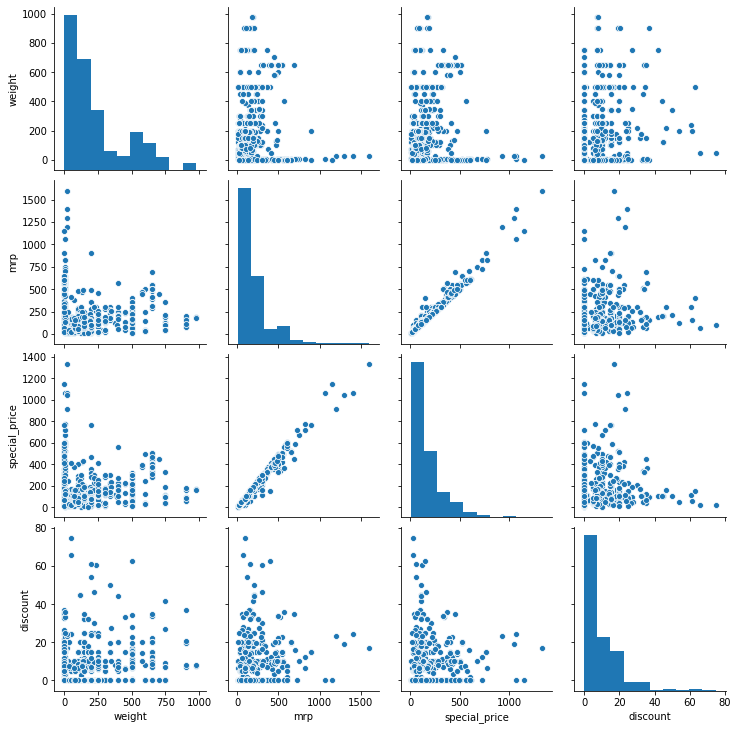

In [29]:
#Scatter plot for all attributes
sns.pairplot(items)
plt.show()

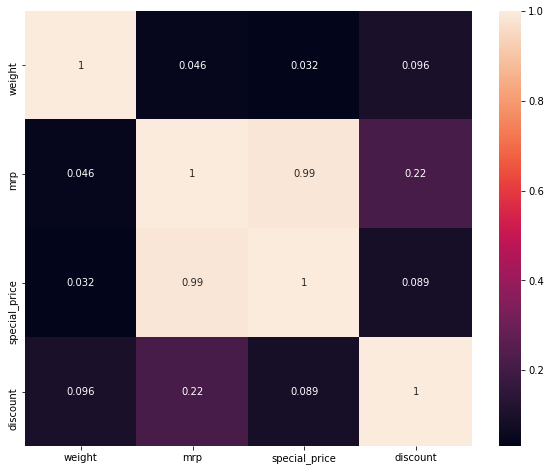

In [30]:
#Heatmap for all attributes
plt.figure(figsize = (10,8))
corr = items.corr()
sns.heatmap(corr, annot=True)
plt.show()



###### Inference: The above heat map shows there is a tight correlation between mrp and special_price.

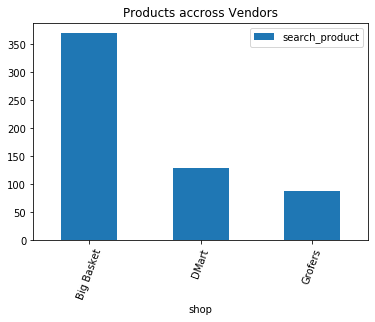

In [31]:
## How many products does each shop have to offer?
prods_shops_df = items[['shop','search_product']]
prod_shops_counts =prods_shops_df.groupby(['shop'],as_index =False).count()
prod_shops_counts.plot.bar(x="shop", y="search_product", rot=70, title="Products accross Vendors");
 

###### Inference: Big Basket has highest number of products available while Grofers has the least. Customers are most likely to find a product in Big Basket.

Text(0, 0.5, 'Count')

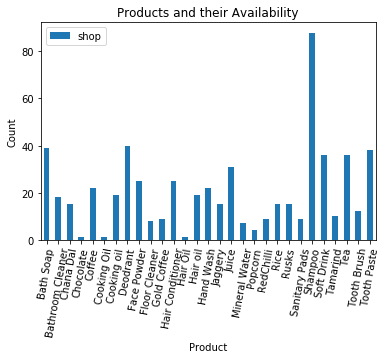

In [32]:
#How many products avaialble for each product category overall
products_count =prods_shops_df.groupby(['search_product'],as_index =False).count()
dataFrame = pd.DataFrame(data=products_count);
y_pos = np.arange(len(dataFrame))
# Draw a vertical bar chart
ax = dataFrame.plot.bar(x="search_product", y="shop", rot=80, title="Products and their Availability");
ax.set_xlabel("Product")
ax.set_ylabel("Count")


In [33]:
###  Number of products sold per product category by each shop 
pd.crosstab(items.shop, items.search_product, margins=True, margins_name="Total",rownames=['shop']).T

shop,Big Basket,DMart,Grofers,Total
search_product,,,,
Bath Soap,37,1,1,39
Bathroom Cleaner,8,9,1,18
Chana Dal,5,5,5,15
Chocolate,1,0,0,1
Coffee,14,3,5,22
Cooking Oil,0,1,0,1
Cooking oil,14,0,5,19
Deodrant,25,10,5,40
Face Powder,20,5,0,25


Text(0, 0.5, 'Product count with discount')

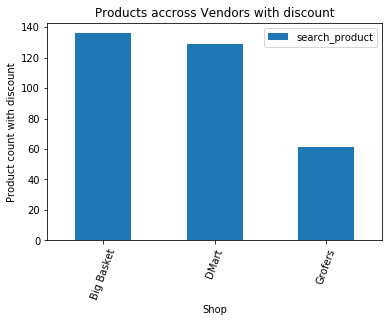

In [34]:
#  Which Individual Products  have Discount
discounts_df = items[ (items.discount > 0.0)]
  
discounts_shop_products = discounts_df[['search_product','shop']]
discounts_per_shop =discounts_shop_products.groupby(['shop'],as_index =False).count()
ax = discounts_per_shop.plot.bar(x="shop", y="search_product", rot=70, title="Products accross Vendors with discount");
ax.set_xlabel("Shop")
ax.set_ylabel("Product count with discount") 
 

###### Inference: DMart offers the most discounts. So customers looking for discounts should visit DMart.

## Recommendation  


Ensure combined.csv file is present in current path before executing following recommendation code.

In [35]:
#Import necessary libraries for user interface
from ipywidgets import interact, Dropdown, HTML, Layout, Box, Label
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

#Read data into dataframe
df_combined = pd.read_csv("combined.csv")

#Unique product types that the user can buy
products_list = df_combined["search_product"].unique()     

#Create dropdown widgets for the user to interact
product_type_dropdown = Dropdown(description="Product Type:", options = products_list)
product_names_dropdown = Dropdown(description="Product:")
product_sizes_dropdown = Dropdown(description="Size:")
recommendation_html = HTML(
    value=" ",
    placeholder='',
    description='',  layout={'width': 'max-content'}
)

box = Box(
    [
        Label(value='Recommendation:'),
        recommendation_html
    ]
) 
#Event handler when product category changes
def update_product_name_options(change):  
    product_type = product_type_dropdown.value         
    df_product = df_combined[  df_combined.search_product.str.lower().str.contains(product_type.lower())    ]
    products = df_product["product_name"].unique()
    product_names_dropdown.options = products
product_type_dropdown.observe(update_product_name_options )
 
#Event handler when product name changes
def update_product_size_options(change): 
    if change['name'] == 'value' and (change['new'] != change['old']):
        product_type = product_type_dropdown.value
        product_name = product_names_dropdown.value
        df_product = df_combined[  df_combined.search_product.str.lower().str.contains(product_type.lower())    ]
        product_name = product_name.replace("+", "\+")
        df_product = df_product[  df_product.product_name.str.lower().str.contains(product_name.lower())   ] 
        product_sizes = df_product["weight_measure"].unique()
        product_sizes_dropdown.options = product_sizes
product_names_dropdown.observe(update_product_size_options )

#Event handler when product size changes
def recommend_product(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        product_type = product_type_dropdown.value
        product_name = product_names_dropdown.value
        product_size = product_sizes_dropdown.value
        recommendation_html.value=""
        product_name = product_name.replace("+", "\+")
        if(product_size):
            df_final_list = df_combined[ df_combined.search_product.str.lower().str.contains(product_type.lower()) & 
                                         df_combined.product_name.str.lower().str.contains(product_name.lower()) & 
                                         df_combined.weight_measure.str.lower().str.contains(product_size.lower()) ] 
            df_final_list.sort_values(by='special_price', inplace=True)
            discount = round(  df_final_list[ "discount"].iloc[0] , 2)
            recommendation_html.value= "Buy it from <b>" + df_final_list.shop.iloc[0] + "</b> for Rs."  + str(df_final_list[ "special_price"].iloc[0])  + " discount of " + str(discount) + "%"
product_sizes_dropdown.observe(recommend_product )

#Display all user interface elements 
display(product_type_dropdown)
display(product_names_dropdown)
display(product_sizes_dropdown)
display(box)
update_product_name_options(None )
    

Dropdown(description='Product Type:', options=('Bath Soap', 'Bathroom Cleaner', 'Chana Dal', 'Chocolate', 'Cof…

Dropdown(description='Product:', options=(), value=None)

Dropdown(description='Size:', options=(), value=None)

Box(children=(Label(value='Recommendation:'), HTML(value=' ', layout=Layout(width='max-content'), placeholder=…